In [1]:
# Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import mse
from tensorflow.linalg import matmul
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import Model

In [2]:
# Loading the dataset
(x_train, _), (x_test, _) = load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
28 * 28

784

* **Jacobian Regularization:** The contractive autoencoder introduces an additional regularization term that penalizes the Jacobian of the encoder function. This regularization term helps the model learn robust features and encourages the encoder to be less sensitive to small changes in the input. The absence of a sigmoid function in the final layer does not directly affect this regularization term, as it is focused on the encoder part of the network.

* In summary, the decision to not use a sigmoid activation function in the final dense layer allows the contractive autoencoder more flexibility in reconstructing the input data. This approach is particularly suitable when dealing with raw pixel values and when using loss functions like MSE that do not require outputs to be in a specific range. The model's architecture and the specific regularization applied (such as Jacobian regularization in contractive autoencoders) are designed to ensure that the learned representations are robust and meaningful, without the need to constrain the final output values.

In [5]:
# Building the model
class ContractiveAutoencoder(Model):
    def __init__(self):
        super(ContractiveAutoencoder, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        self.bottleneck = Dense(16, activation='relu')
        self.dense4 = Dense(32, activation='relu')
        self.dense5 = Dense(64, activation='relu')
        self.dense_final = Dense(784) # 28 * 28 --> input shape dimensions

    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x_hid = x
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped, x_hid

In [6]:
# Defining the loss function and the gradient
def loss(x, x_bar, h, model, Lambda=100):
    reconstruction_loss = tf.reduce_mean(mse(x, x_bar))
    reconstruction_loss *= 28 * 28
    W = tf.Variable(model.bottleneck.weights[0])
    dh = h * (1-h) #N-batch x N_hidden
    W = tf.transpose(W)
    contractive = Lambda * tf.reduce_sum(matmul(dh**2, tf.square(W)), axis = 1)
    total_loss = reconstruction_loss + contractive
    return total_loss

**def loss(x, x_bar, h, model, Lambda=100):** : This line defines a function named loss that takes the following parameters:
* **x**: The original input data.
* **x_bar**: The reconstructed input data from the autoencoder.
* **h**: The hidden representation (output of the bottleneck layer).
* **model**: The autoencoder model.
* **Lambda**: A **regularization parameter** (default value is 100) that controls the weight of the contractive term in the total loss.

* **reconstruction_loss = tf.reduce_mean(mse(x, x_bar))**: This line calculates the mean squared error (MSE) between the original input x and the reconstructed output x_bar. mse is presumably a function that computes the element-wise squared difference between x and x_bar, and tf.reduce_mean computes the average of these squared differences.
  
* **reconstruction_loss** * **= 28 * 28**: This line scales the reconstruction loss by the size of the input image (assuming 28 * 28 pixels, typical for MNIST dataset images). This scaling ensures that the loss value is appropriately scaled to account for the total number of pixels.

* **W = tf.Variable(model.bottleneck.weights[0])**: This line extracts the weights of the bottleneck (encoder) layer from the model and stores them in a TensorFlow variable W. The **weights are used in the computation of the Jacobian regularization term**.

* **dh = h * (1-h):** This line computes the derivative of the hidden representation h with respect to the input.

* **W = tf.transpose(W)**: This line transposes the weight matrix W. This transposition is necessary for the matrix multiplication in the next step to align the dimensions correctly.

**contractive = Lambda * tf.reduce_sum(matmul(dh^2, tf.square(W)), axis = 1)**: This line computes the contractive loss:

* **dh^2** squares each element of the derivative dh.

* **tf.square(W)** squares each element of the transposed weight matrix W.

* **matmul(dh^2, tf.square(W))** performs matrix multiplication between the squared derivatives and the squared weights.

* **tf.reduce_sum(..., axis=1)** sums the result across the hidden units (columns), yielding a contractive loss for each instance in the batch.
The resulting sum is scaled by the regularization parameter Lambda.

* **total_loss = reconstruction_loss + contractive**: This line computes the total loss as the sum of the reconstruction loss and the contractive loss.

In [7]:
# Defining the gradient
def grad(model, inputs):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped, hidden = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction, hidden, model)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction

* **with tf.GradientTape() as tape:** : This line **opens a context block for tf.GradientTape, which records operations for automatic differentiation**. The tape will watch the operations performed on tensors, enabling the computation of gradients with respect to those tensors.

**reconstruction, inputs_reshaped, hidden = model(inputs)**: This line performs a forward pass through the model using the input data:
* **inputs**: The original input data fed into the model.
* **reconstruction**: The reconstructed input data.
* **inputs_reshaped**: The reshaped input data, typically the output of the flatten layer.
* **hidden**: The hidden representation (output of the bottleneck layer).

* **loss_value = loss(inputs_reshaped, reconstruction, hidden, model)**: This line calculates the loss value using the previously defined loss function. The loss function takes the reshaped inputs, the reconstructed output, the hidden representation, and the model as arguments.

* **tape.gradient(loss_value, model.trainable_variables)**: The gradients of the loss value with respect to the model's trainable variables. **tape.gradient** computes these gradients using the operations recorded in the **tf.GradientTape** context.

In [9]:
# Training the model
model = ContractiveAutoencoder()
optimizer = Adam(learning_rate=0.001)
global_step = tf.Variable(0)
num_epochs = 200
batch_size = 128
for epoch in range(num_epochs):
    print("Epoch ", epoch)
    for x in range(0, len(x_train), batch_size):
        x_inp = x_train[x : x + batch_size]
        loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

    print("Step: {}, Loss: {}".format(global_step.numpy(), tf.reduce_sum(loss_value)))

Epoch  0
Step: 0, Loss: 3367.23876953125
Epoch  1
Step: 0, Loss: 2861.3623046875
Epoch  2
Step: 0, Loss: 2637.5869140625
Epoch  3
Step: 0, Loss: 2477.2646484375
Epoch  4
Step: 0, Loss: 2355.246337890625
Epoch  5
Step: 0, Loss: 2239.2509765625
Epoch  6
Step: 0, Loss: 2146.629150390625
Epoch  7
Step: 0, Loss: 2093.83544921875
Epoch  8
Step: 0, Loss: 2069.414794921875
Epoch  9
Step: 0, Loss: 2020.662109375
Epoch  10
Step: 0, Loss: 2002.333984375
Epoch  11
Step: 0, Loss: 1994.3768310546875
Epoch  12
Step: 0, Loss: 1988.5872802734375
Epoch  13
Step: 0, Loss: 1981.029541015625
Epoch  14
Step: 0, Loss: 1976.7403564453125
Epoch  15
Step: 0, Loss: 1921.42138671875
Epoch  16
Step: 0, Loss: 1949.67431640625
Epoch  17
Step: 0, Loss: 1923.9163818359375
Epoch  18
Step: 0, Loss: 1940.21240234375
Epoch  19
Step: 0, Loss: 1996.492431640625
Epoch  20
Step: 0, Loss: 1907.2041015625
Epoch  21
Step: 0, Loss: 1911.569091796875
Epoch  22
Step: 0, Loss: 1956.5755615234375
Epoch  23
Step: 0, Loss: 2047.9005126

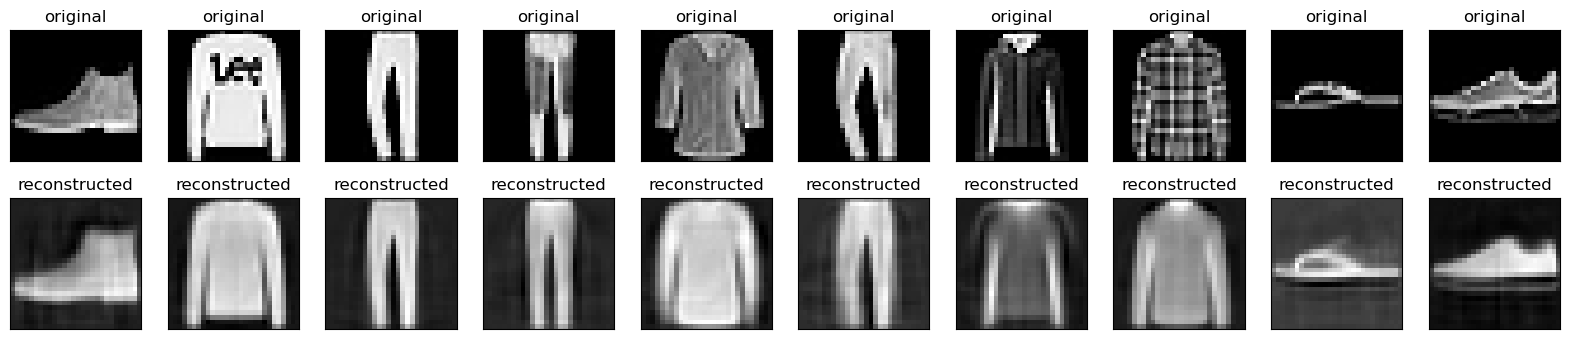

In [11]:
# generating the results
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    #display the original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    reconstruction, inputs_reshaped,hidden = model(x_test[i].reshape((1,784)))
    plt.imshow(reconstruction.numpy().reshape((28,28)))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()